### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 126 elements
My custom valing-dataset has 42 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

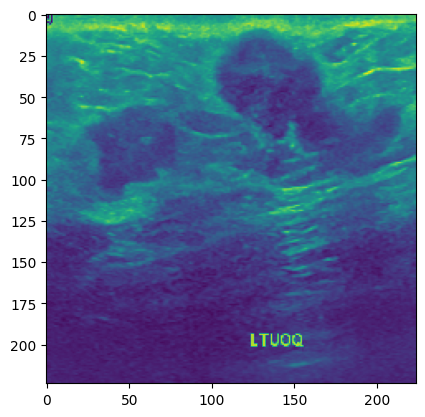

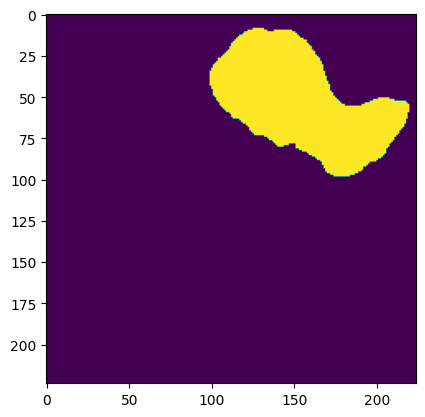

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_medical_seg_models.nnunet import Nested_UNet as UNet_2p

model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'UNet++'
data_name = 'malignant'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 16 of 16, Train Loss: 1.326295, IoU: 0.266967, Dice: 0.386212
 Epoch: 1 of 100, Iter.: 16 of 16, Valid Loss: 1.424469, IoU: 0.000000, Dice: 0.000000

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


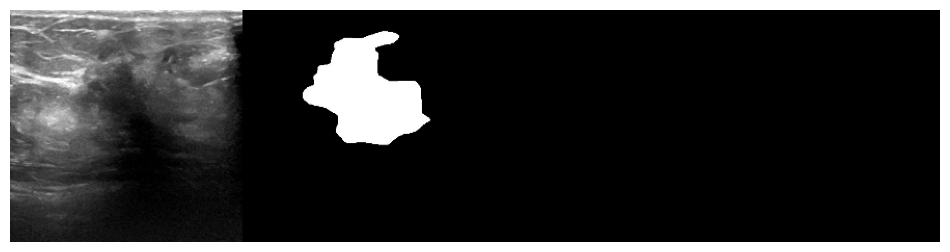

 Epoch: 2 of 100, Iter.: 16 of 16, Train Loss: 1.154923, IoU: 0.405231, Dice: 0.545283
 Epoch: 2 of 100, Iter.: 16 of 16, Valid Loss: 1.425851, IoU: 0.203499, Dice: 0.320428


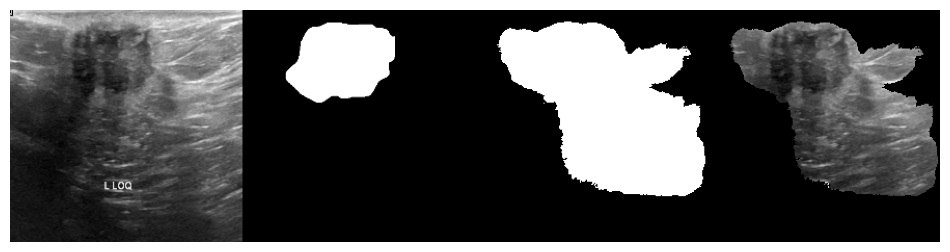

 Epoch: 3 of 100, Iter.: 16 of 16, Train Loss: 1.090501, IoU: 0.426092, Dice: 0.566468
 Epoch: 3 of 100, Iter.: 16 of 16, Valid Loss: 1.205326, IoU: 0.340932, Dice: 0.466689


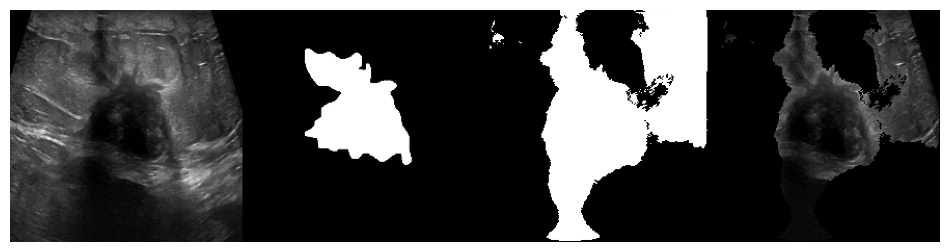

 Epoch: 4 of 100, Iter.: 16 of 16, Train Loss: 1.040863, IoU: 0.489749, Dice: 0.624988
 Epoch: 4 of 100, Iter.: 16 of 16, Valid Loss: 1.110985, IoU: 0.456686, Dice: 0.600464


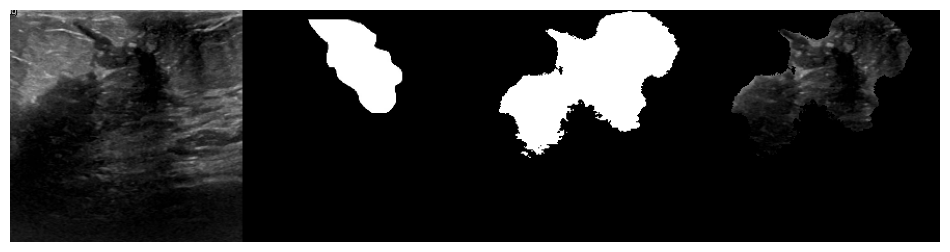

 Epoch: 5 of 100, Iter.: 16 of 16, Train Loss: 1.004734, IoU: 0.536548, Dice: 0.666709
 Epoch: 5 of 100, Iter.: 16 of 16, Valid Loss: 1.112237, IoU: 0.453265, Dice: 0.594868


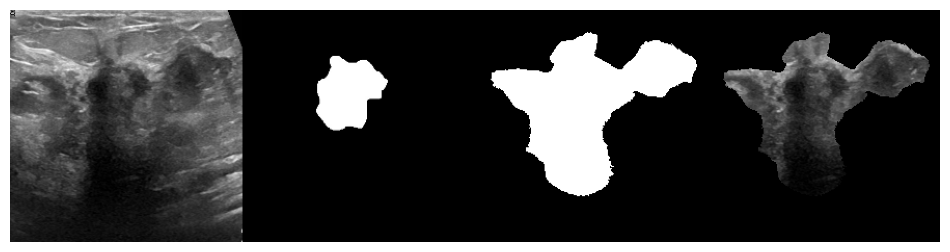

 Epoch: 6 of 100, Iter.: 16 of 16, Train Loss: 0.966706, IoU: 0.566025, Dice: 0.694993
 Epoch: 6 of 100, Iter.: 16 of 16, Valid Loss: 1.077436, IoU: 0.449836, Dice: 0.588856


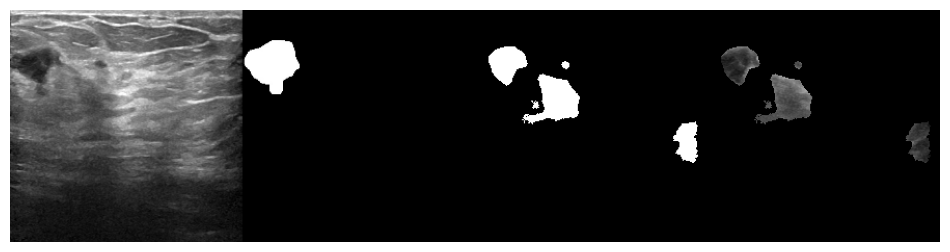

 Epoch: 7 of 100, Iter.: 16 of 16, Train Loss: 0.964884, IoU: 0.543324, Dice: 0.674312
 Epoch: 7 of 100, Iter.: 16 of 16, Valid Loss: 1.463845, IoU: 0.291950, Dice: 0.429081


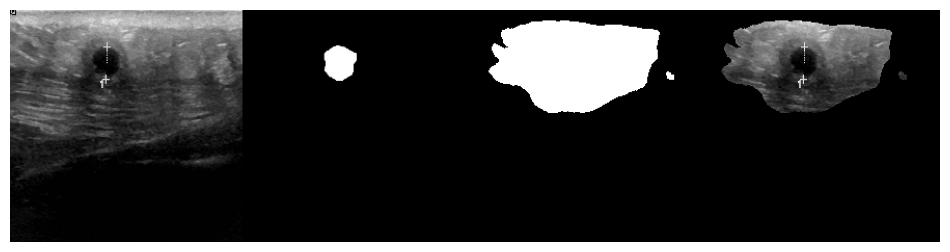

 Epoch: 8 of 100, Iter.: 16 of 16, Train Loss: 0.954802, IoU: 0.567198, Dice: 0.690640
 Epoch: 8 of 100, Iter.: 16 of 16, Valid Loss: 1.033565, IoU: 0.457524, Dice: 0.586186


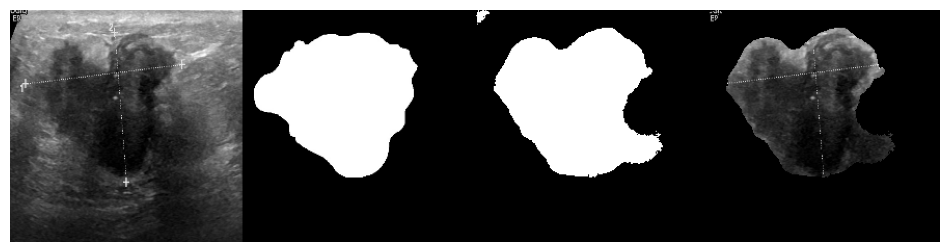

 Epoch: 9 of 100, Iter.: 16 of 16, Train Loss: 0.922265, IoU: 0.590092, Dice: 0.715465
 Epoch: 9 of 100, Iter.: 16 of 16, Valid Loss: 1.016813, IoU: 0.468479, Dice: 0.596460


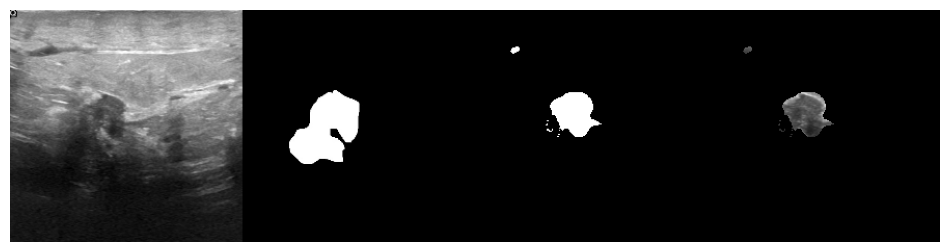

 Epoch: 10 of 100, Iter.: 16 of 16, Train Loss: 0.888908, IoU: 0.618339, Dice: 0.741506
 Epoch: 10 of 100, Iter.: 16 of 16, Valid Loss: 0.992127, IoU: 0.481123, Dice: 0.614727


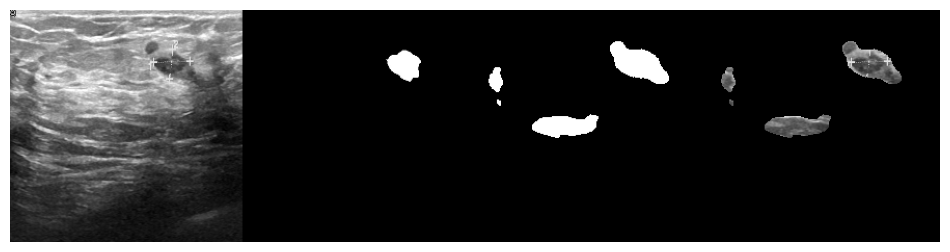

 Epoch: 11 of 100, Iter.: 16 of 16, Train Loss: 0.860241, IoU: 0.667174, Dice: 0.780804
 Epoch: 11 of 100, Iter.: 16 of 16, Valid Loss: 1.283741, IoU: 0.353864, Dice: 0.496400


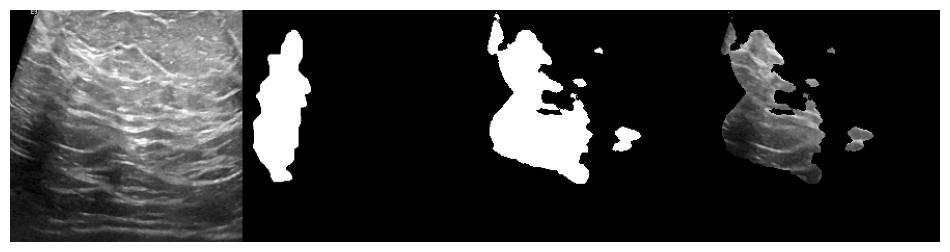

 Epoch: 12 of 100, Iter.: 16 of 16, Train Loss: 0.870080, IoU: 0.629343, Dice: 0.752471
 Epoch: 12 of 100, Iter.: 16 of 16, Valid Loss: 0.980531, IoU: 0.457994, Dice: 0.584781


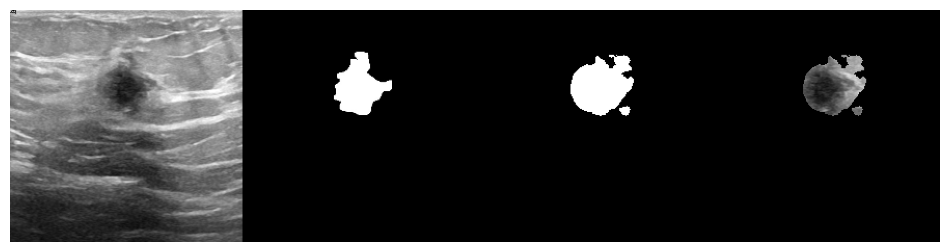

 Epoch: 13 of 100, Iter.: 16 of 16, Train Loss: 0.845213, IoU: 0.657154, Dice: 0.766284
 Epoch: 13 of 100, Iter.: 16 of 16, Valid Loss: 1.017334, IoU: 0.459817, Dice: 0.594233


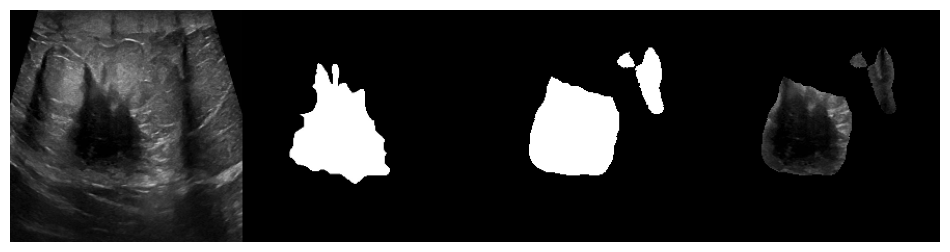

 Epoch: 14 of 100, Iter.: 16 of 16, Train Loss: 0.839697, IoU: 0.646724, Dice: 0.763295
 Epoch: 14 of 100, Iter.: 16 of 16, Valid Loss: 0.934520, IoU: 0.482379, Dice: 0.600006


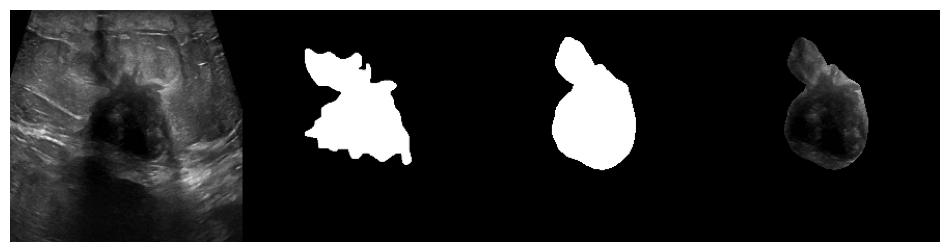

 Epoch: 15 of 100, Iter.: 16 of 16, Train Loss: 0.809368, IoU: 0.693663, Dice: 0.800610
 Epoch: 15 of 100, Iter.: 16 of 16, Valid Loss: 1.079950, IoU: 0.369323, Dice: 0.504362


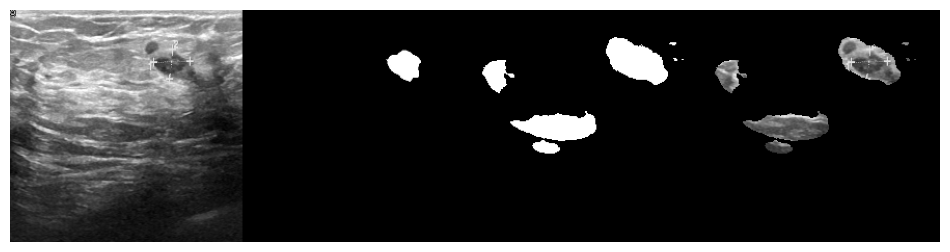

 Epoch: 16 of 100, Iter.: 16 of 16, Train Loss: 0.806585, IoU: 0.678957, Dice: 0.792005
 Epoch: 16 of 100, Iter.: 16 of 16, Valid Loss: 0.925494, IoU: 0.515290, Dice: 0.643282


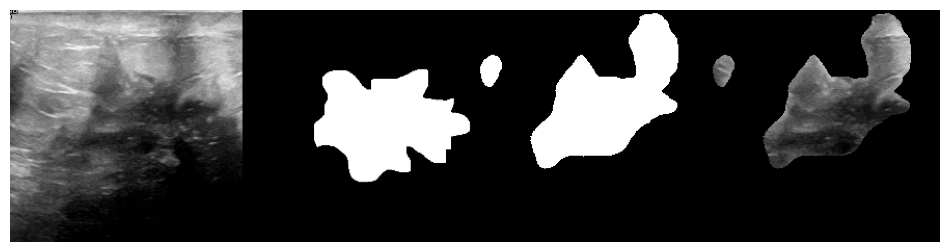

 Epoch: 17 of 100, Iter.: 16 of 16, Train Loss: 0.774870, IoU: 0.735740, Dice: 0.836057
 Epoch: 17 of 100, Iter.: 16 of 16, Valid Loss: 1.019001, IoU: 0.367245, Dice: 0.474765


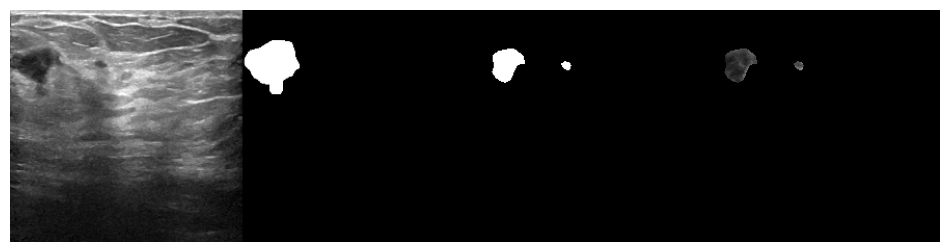

 Epoch: 18 of 100, Iter.: 16 of 16, Train Loss: 0.761292, IoU: 0.731547, Dice: 0.832869
 Epoch: 18 of 100, Iter.: 16 of 16, Valid Loss: 0.954483, IoU: 0.479825, Dice: 0.611635


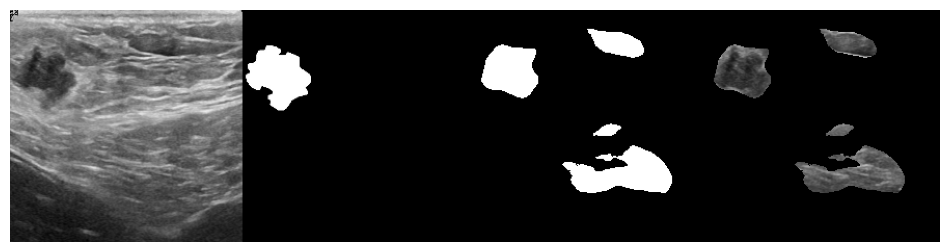

 Epoch: 19 of 100, Iter.: 16 of 16, Train Loss: 0.742962, IoU: 0.746208, Dice: 0.844698
 Epoch: 19 of 100, Iter.: 16 of 16, Valid Loss: 0.930656, IoU: 0.503164, Dice: 0.629598


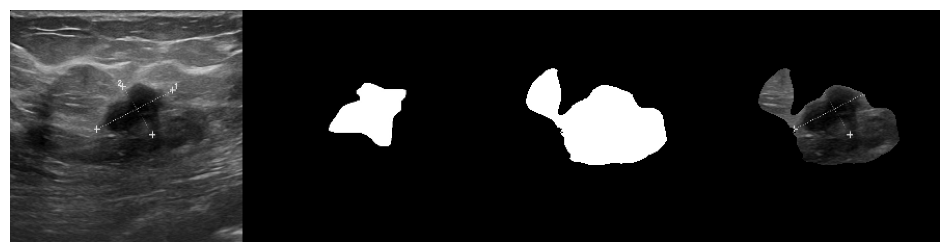

 Epoch: 20 of 100, Iter.: 16 of 16, Train Loss: 0.746673, IoU: 0.734271, Dice: 0.832950
 Epoch: 20 of 100, Iter.: 16 of 16, Valid Loss: 0.977363, IoU: 0.441186, Dice: 0.567635


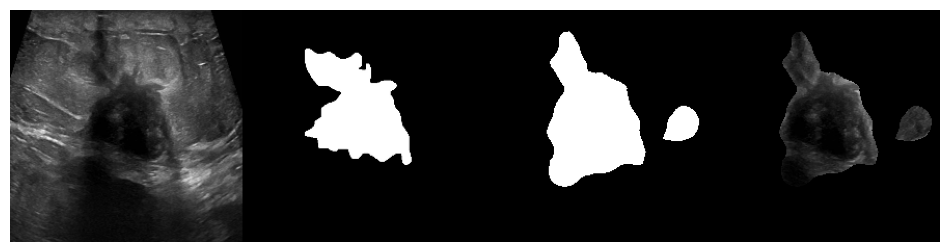

 Epoch: 21 of 100, Iter.: 16 of 16, Train Loss: 0.710527, IoU: 0.766747, Dice: 0.858913
 Epoch: 21 of 100, Iter.: 16 of 16, Valid Loss: 0.892072, IoU: 0.525398, Dice: 0.651674


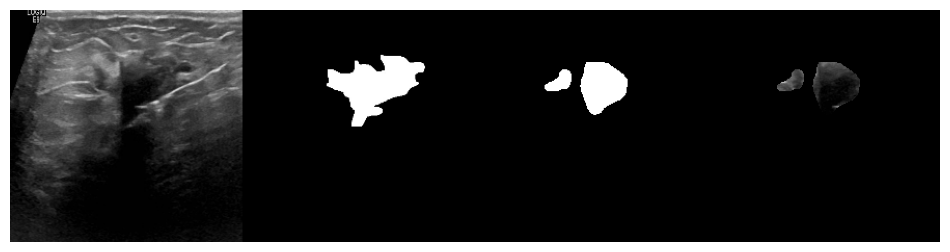

 Epoch: 22 of 100, Iter.: 16 of 16, Train Loss: 0.690454, IoU: 0.786114, Dice: 0.869699
 Epoch: 22 of 100, Iter.: 16 of 16, Valid Loss: 0.943721, IoU: 0.442285, Dice: 0.555318


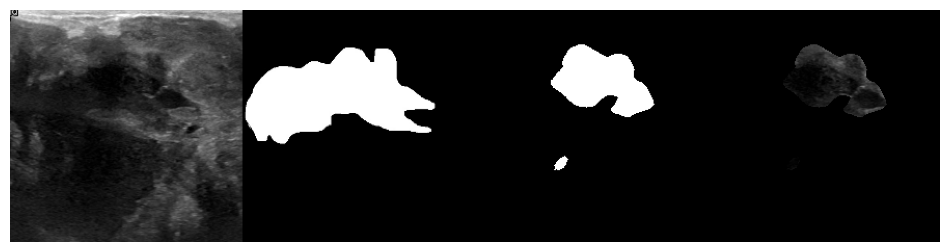

 Epoch: 23 of 100, Iter.: 16 of 16, Train Loss: 0.681603, IoU: 0.799917, Dice: 0.883859
 Epoch: 23 of 100, Iter.: 16 of 16, Valid Loss: 0.922776, IoU: 0.463877, Dice: 0.582677


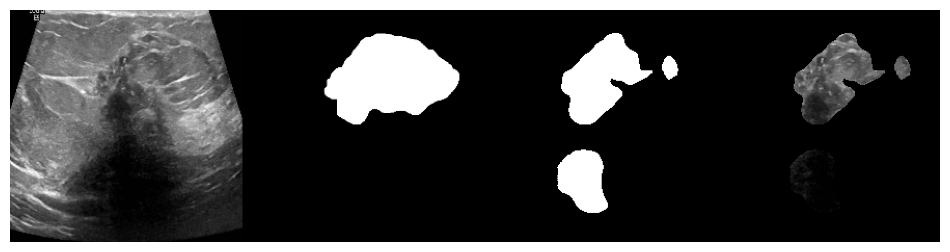

 Epoch: 24 of 100, Iter.: 16 of 16, Train Loss: 0.676959, IoU: 0.810632, Dice: 0.890699
 Epoch: 24 of 100, Iter.: 16 of 16, Valid Loss: 0.918509, IoU: 0.504292, Dice: 0.628255


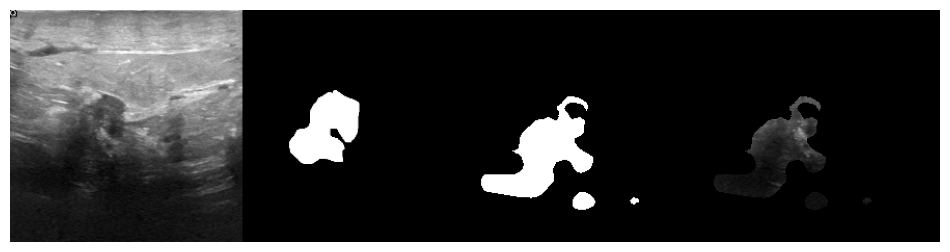

 Epoch: 25 of 100, Iter.: 16 of 16, Train Loss: 0.666259, IoU: 0.813045, Dice: 0.889723
 Epoch: 25 of 100, Iter.: 16 of 16, Valid Loss: 0.954179, IoU: 0.480001, Dice: 0.613980


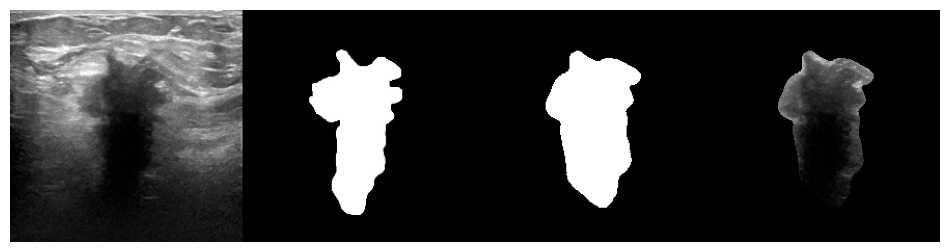

 Epoch: 26 of 100, Iter.: 16 of 16, Train Loss: 0.672286, IoU: 0.798397, Dice: 0.880756
 Epoch: 26 of 100, Iter.: 16 of 16, Valid Loss: 0.912714, IoU: 0.462428, Dice: 0.589525


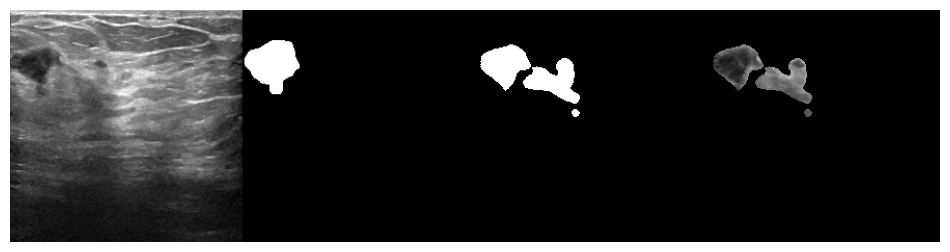

 Epoch: 27 of 100, Iter.: 16 of 16, Train Loss: 0.639315, IoU: 0.821662, Dice: 0.897509
 Epoch: 27 of 100, Iter.: 16 of 16, Valid Loss: 0.859096, IoU: 0.521753, Dice: 0.649682


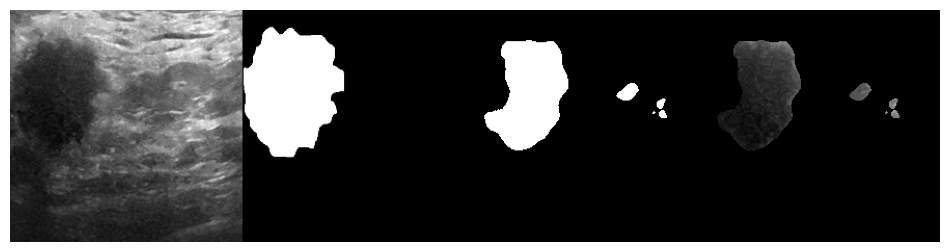

 Epoch: 28 of 100, Iter.: 16 of 16, Train Loss: 0.630558, IoU: 0.825924, Dice: 0.897902
 Epoch: 28 of 100, Iter.: 16 of 16, Valid Loss: 0.870717, IoU: 0.536187, Dice: 0.662854


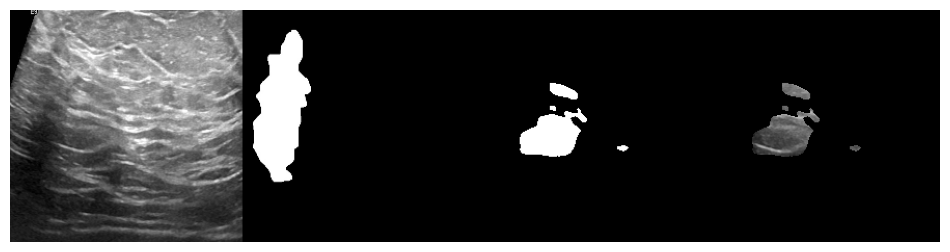

 Epoch: 29 of 100, Iter.: 16 of 16, Train Loss: 0.622228, IoU: 0.833756, Dice: 0.906291
 Epoch: 29 of 100, Iter.: 16 of 16, Valid Loss: 0.859188, IoU: 0.503472, Dice: 0.624572


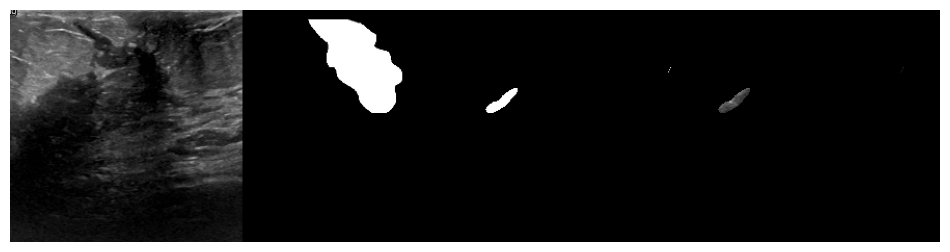

 Epoch: 30 of 100, Iter.: 16 of 16, Train Loss: 0.618182, IoU: 0.829523, Dice: 0.901516
 Epoch: 30 of 100, Iter.: 16 of 16, Valid Loss: 0.836058, IoU: 0.536438, Dice: 0.659933


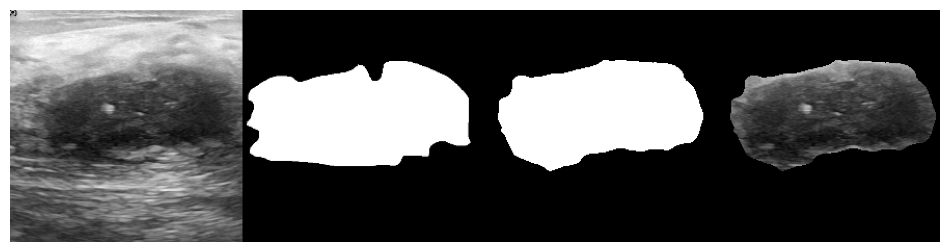

 Epoch: 31 of 100, Iter.: 16 of 16, Train Loss: 0.601225, IoU: 0.837560, Dice: 0.906201
 Epoch: 31 of 100, Iter.: 16 of 16, Valid Loss: 0.842708, IoU: 0.523631, Dice: 0.645853


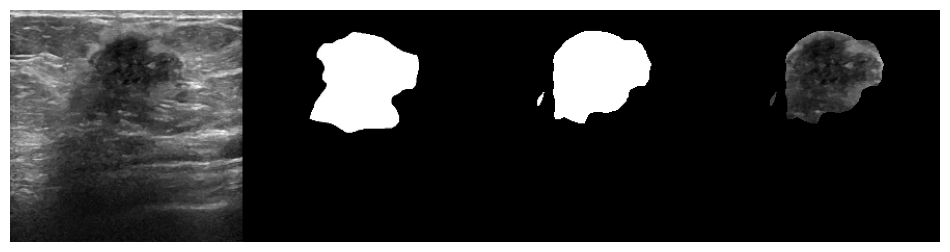

 Epoch: 32 of 100, Iter.: 16 of 16, Train Loss: 0.571752, IoU: 0.867231, Dice: 0.927589
 Epoch: 32 of 100, Iter.: 16 of 16, Valid Loss: 0.827505, IoU: 0.547411, Dice: 0.666272


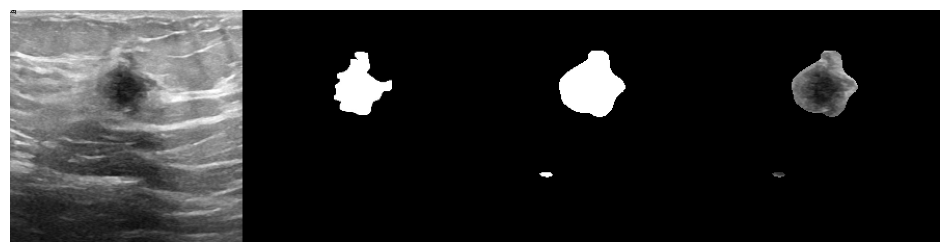

 Epoch: 33 of 100, Iter.: 16 of 16, Train Loss: 0.566667, IoU: 0.870393, Dice: 0.928693
 Epoch: 33 of 100, Iter.: 16 of 16, Valid Loss: 0.816448, IoU: 0.550302, Dice: 0.674060


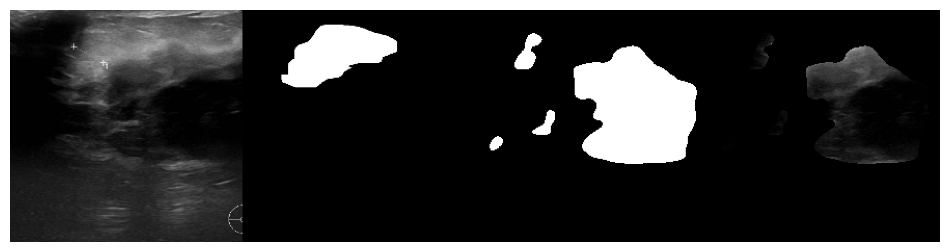

 Epoch: 34 of 100, Iter.: 16 of 16, Train Loss: 0.550362, IoU: 0.880386, Dice: 0.933996
 Epoch: 34 of 100, Iter.: 16 of 16, Valid Loss: 0.838684, IoU: 0.513460, Dice: 0.633134


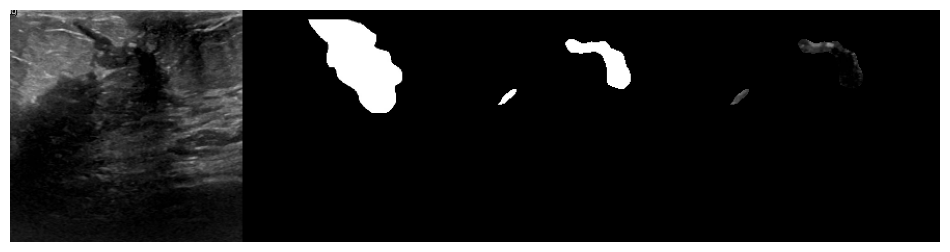

 Epoch: 35 of 100, Iter.: 16 of 16, Train Loss: 0.546361, IoU: 0.885828, Dice: 0.938470
 Epoch: 35 of 100, Iter.: 16 of 16, Valid Loss: 0.827436, IoU: 0.535516, Dice: 0.664200


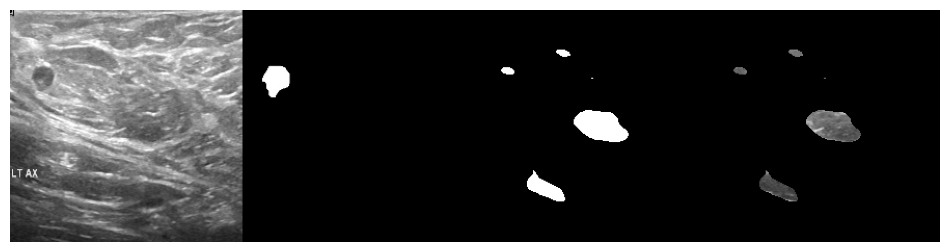

 Epoch: 36 of 100, Iter.: 16 of 16, Train Loss: 0.547750, IoU: 0.872821, Dice: 0.929362
 Epoch: 36 of 100, Iter.: 16 of 16, Valid Loss: 0.797711, IoU: 0.552063, Dice: 0.679373


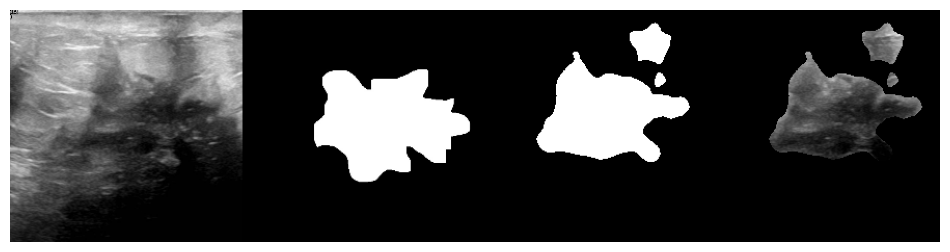

 Epoch: 37 of 100, Iter.: 16 of 16, Train Loss: 0.537587, IoU: 0.887743, Dice: 0.938832
 Epoch: 37 of 100, Iter.: 16 of 16, Valid Loss: 0.826766, IoU: 0.526863, Dice: 0.656466


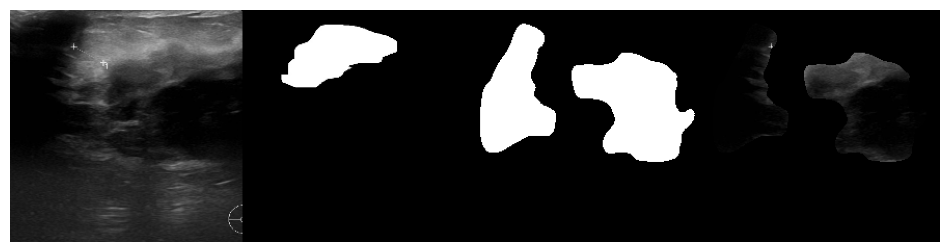

 Epoch: 38 of 100, Iter.: 16 of 16, Train Loss: 0.525918, IoU: 0.888656, Dice: 0.939728
 Epoch: 38 of 100, Iter.: 16 of 16, Valid Loss: 0.784938, IoU: 0.554067, Dice: 0.672893


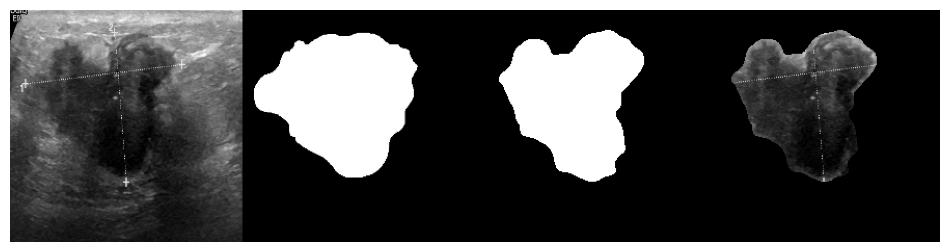

 Epoch: 39 of 100, Iter.: 16 of 16, Train Loss: 0.506744, IoU: 0.899944, Dice: 0.946674
 Epoch: 39 of 100, Iter.: 16 of 16, Valid Loss: 0.791791, IoU: 0.544376, Dice: 0.665734


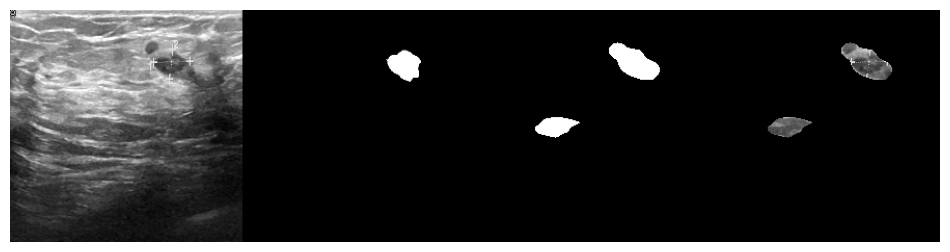

 Epoch: 40 of 100, Iter.: 16 of 16, Train Loss: 0.502959, IoU: 0.902468, Dice: 0.948225
 Epoch: 40 of 100, Iter.: 16 of 16, Valid Loss: 0.772275, IoU: 0.565876, Dice: 0.687851


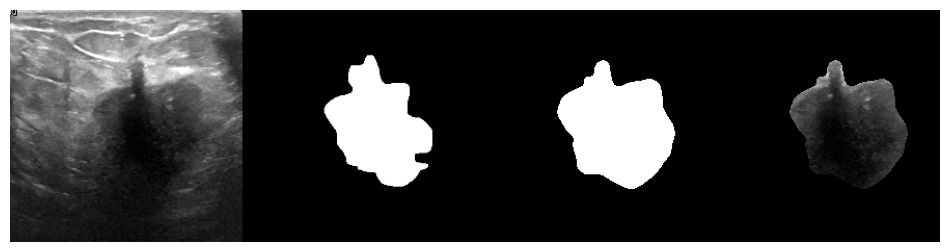

 Epoch: 41 of 100, Iter.: 16 of 16, Train Loss: 0.497220, IoU: 0.901181, Dice: 0.946924
 Epoch: 41 of 100, Iter.: 16 of 16, Valid Loss: 0.792399, IoU: 0.537160, Dice: 0.660793


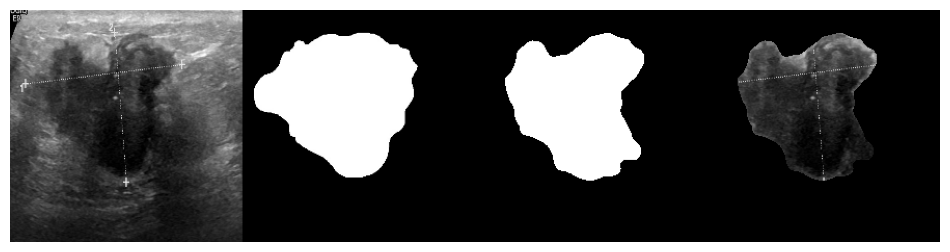

 Epoch: 42 of 100, Iter.: 16 of 16, Train Loss: 0.484373, IoU: 0.905832, Dice: 0.949938
 Epoch: 42 of 100, Iter.: 16 of 16, Valid Loss: 0.761026, IoU: 0.553098, Dice: 0.672785


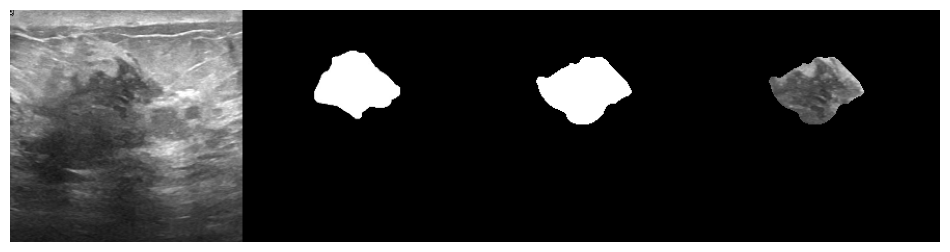

 Epoch: 43 of 100, Iter.: 16 of 16, Train Loss: 0.483467, IoU: 0.902404, Dice: 0.947637
 Epoch: 43 of 100, Iter.: 16 of 16, Valid Loss: 0.764292, IoU: 0.552742, Dice: 0.674453


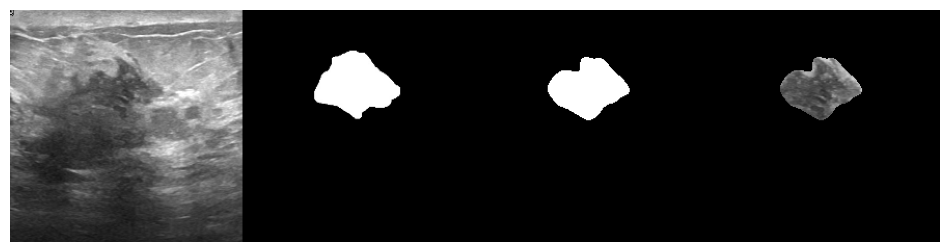

 Epoch: 44 of 100, Iter.: 16 of 16, Train Loss: 0.470626, IoU: 0.908992, Dice: 0.951254
 Epoch: 44 of 100, Iter.: 16 of 16, Valid Loss: 0.770099, IoU: 0.547077, Dice: 0.675439


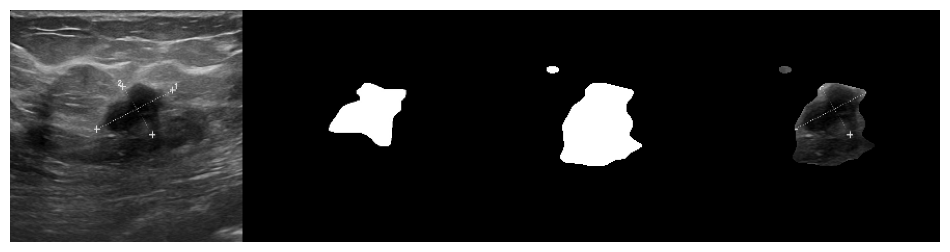

 Epoch: 45 of 100, Iter.: 16 of 16, Train Loss: 0.468185, IoU: 0.909101, Dice: 0.951790
 Epoch: 45 of 100, Iter.: 16 of 16, Valid Loss: 0.766707, IoU: 0.541785, Dice: 0.662224


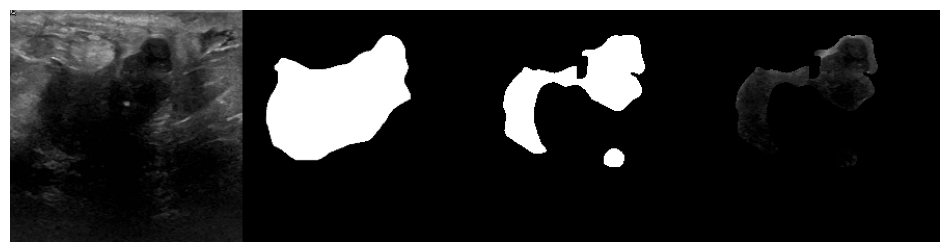

 Epoch: 46 of 100, Iter.: 16 of 16, Train Loss: 0.460446, IoU: 0.909060, Dice: 0.951454
 Epoch: 46 of 100, Iter.: 16 of 16, Valid Loss: 0.764087, IoU: 0.538041, Dice: 0.660168


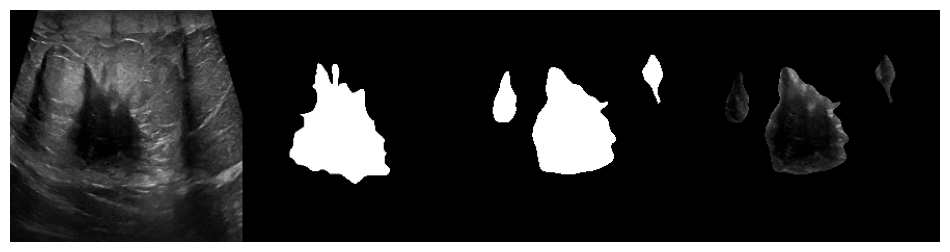

 Epoch: 47 of 100, Iter.: 16 of 16, Train Loss: 0.464116, IoU: 0.889065, Dice: 0.935892
 Epoch: 47 of 100, Iter.: 16 of 16, Valid Loss: 0.835981, IoU: 0.504547, Dice: 0.638462


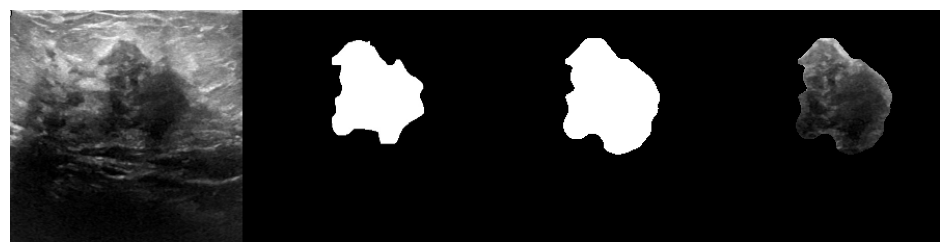

 Epoch: 48 of 100, Iter.: 16 of 16, Train Loss: 0.494418, IoU: 0.819284, Dice: 0.890184
 Epoch: 48 of 100, Iter.: 16 of 16, Valid Loss: 1.364307, IoU: 0.376377, Dice: 0.512569


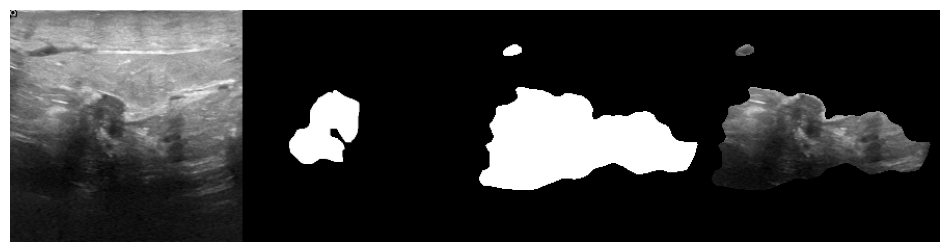

 Epoch: 49 of 100, Iter.: 16 of 16, Train Loss: 0.534717, IoU: 0.763106, Dice: 0.847195
 Epoch: 49 of 100, Iter.: 16 of 16, Valid Loss: 1.179118, IoU: 0.378933, Dice: 0.522831


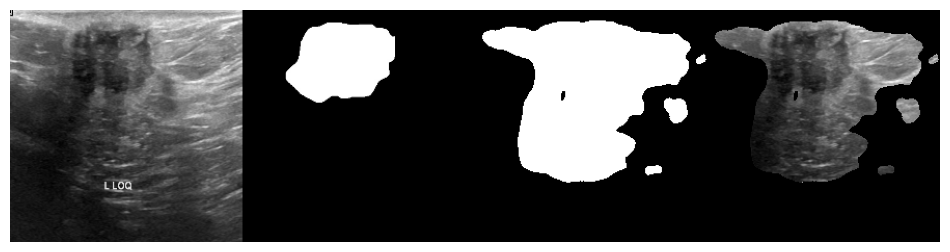

 Epoch: 50 of 100, Iter.: 16 of 16, Train Loss: 0.516164, IoU: 0.788250, Dice: 0.873917
 Epoch: 50 of 100, Iter.: 16 of 16, Valid Loss: 0.919861, IoU: 0.363921, Dice: 0.471198


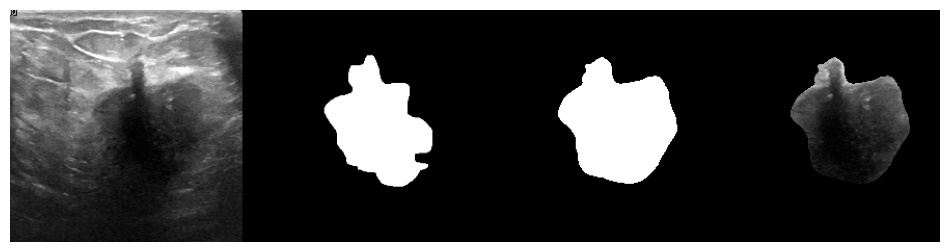

 Epoch: 51 of 100, Iter.: 16 of 16, Train Loss: 0.512785, IoU: 0.781879, Dice: 0.865471
 Epoch: 51 of 100, Iter.: 16 of 16, Valid Loss: 0.777224, IoU: 0.453392, Dice: 0.572480


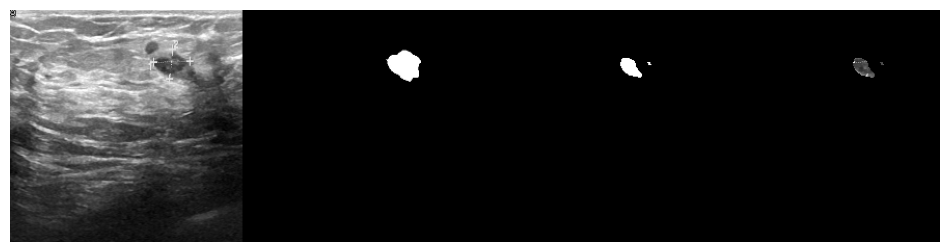

 Epoch: 52 of 100, Iter.: 16 of 16, Train Loss: 0.469794, IoU: 0.836421, Dice: 0.906543
 Epoch: 52 of 100, Iter.: 16 of 16, Valid Loss: 0.736573, IoU: 0.536842, Dice: 0.663156


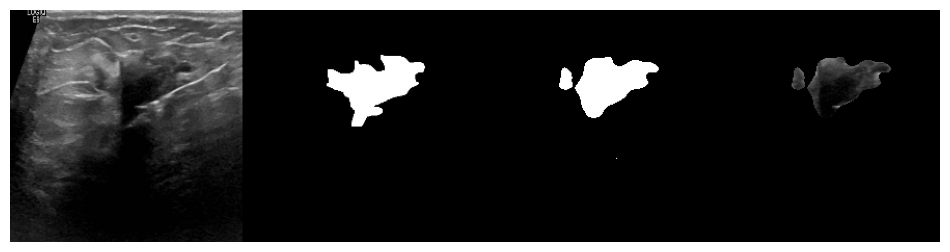

 Epoch: 53 of 100, Iter.: 16 of 16, Train Loss: 0.460010, IoU: 0.841635, Dice: 0.907556
 Epoch: 53 of 100, Iter.: 16 of 16, Valid Loss: 0.777921, IoU: 0.476200, Dice: 0.605687


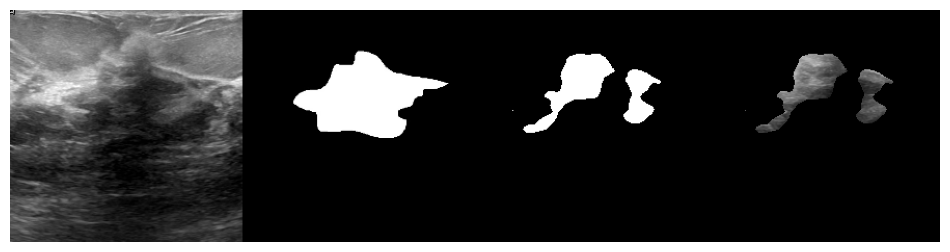

 Epoch: 54 of 100, Iter.: 16 of 16, Train Loss: 0.446186, IoU: 0.856273, Dice: 0.919053
 Epoch: 54 of 100, Iter.: 16 of 16, Valid Loss: 0.830170, IoU: 0.420197, Dice: 0.529778


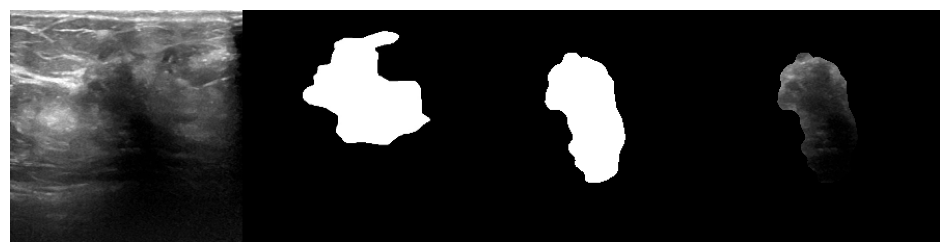

 Epoch: 55 of 100, Iter.: 16 of 16, Train Loss: 0.408147, IoU: 0.887675, Dice: 0.938406
 Epoch: 55 of 100, Iter.: 16 of 16, Valid Loss: 0.761412, IoU: 0.497547, Dice: 0.617010


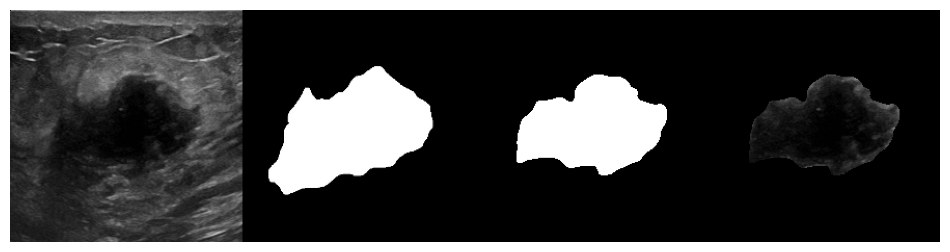

 Epoch: 56 of 100, Iter.: 16 of 16, Train Loss: 0.401726, IoU: 0.902852, Dice: 0.947238
 Epoch: 56 of 100, Iter.: 16 of 16, Valid Loss: 0.714948, IoU: 0.545115, Dice: 0.666550


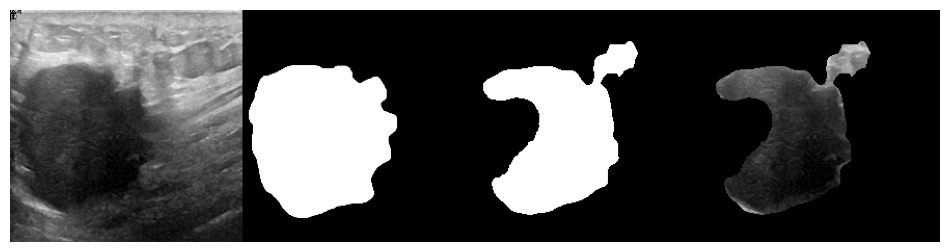

 Epoch: 57 of 100, Iter.: 16 of 16, Train Loss: 0.388022, IoU: 0.915229, Dice: 0.954865
 Epoch: 57 of 100, Iter.: 16 of 16, Valid Loss: 0.711401, IoU: 0.550314, Dice: 0.669662


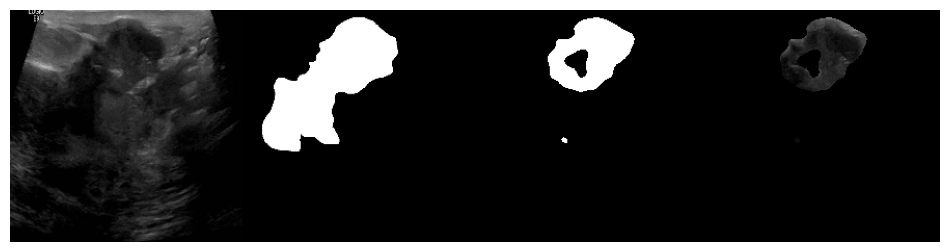

 Epoch: 58 of 100, Iter.: 16 of 16, Train Loss: 0.381129, IoU: 0.921845, Dice: 0.958920
 Epoch: 58 of 100, Iter.: 16 of 16, Valid Loss: 0.705553, IoU: 0.540993, Dice: 0.662360


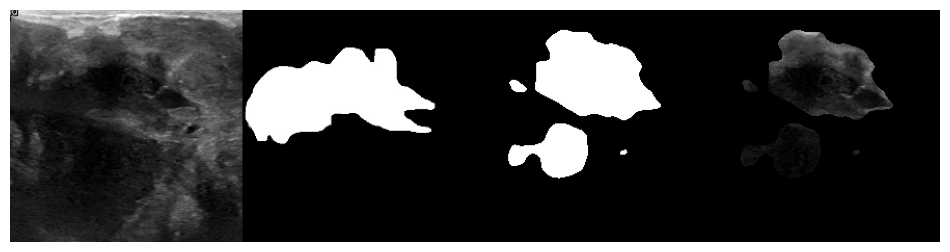

 Epoch: 59 of 100, Iter.: 16 of 16, Train Loss: 0.366077, IoU: 0.934112, Dice: 0.965607
 Epoch: 59 of 100, Iter.: 16 of 16, Valid Loss: 0.714497, IoU: 0.544310, Dice: 0.664198


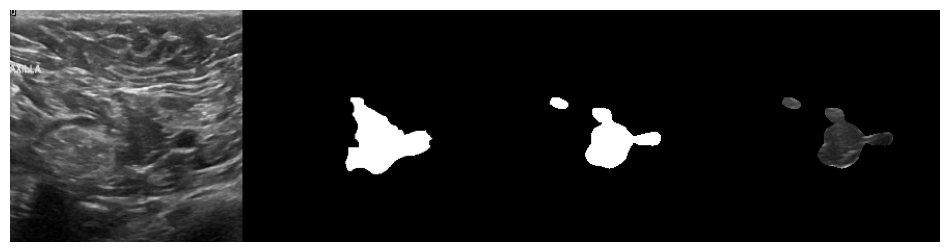

 Epoch: 60 of 100, Iter.: 16 of 16, Train Loss: 0.366621, IoU: 0.930565, Dice: 0.963680
 Epoch: 60 of 100, Iter.: 16 of 16, Valid Loss: 0.700044, IoU: 0.545067, Dice: 0.667719


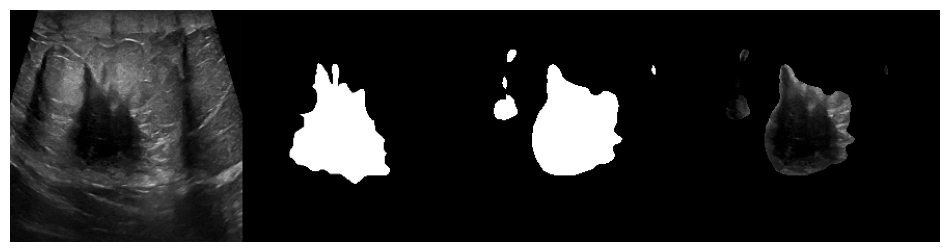

 Epoch: 61 of 100, Iter.: 16 of 16, Train Loss: 0.359255, IoU: 0.931971, Dice: 0.964414
 Epoch: 61 of 100, Iter.: 16 of 16, Valid Loss: 0.701014, IoU: 0.544884, Dice: 0.666612


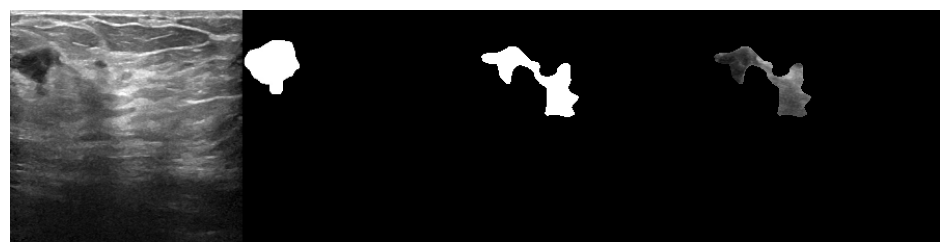


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 3min 4s, sys: 4min 35s, total: 7min 40s
Wall time: 3min 3s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:40, Best_IOU:0.5659, Best_DiceScore:0.6879


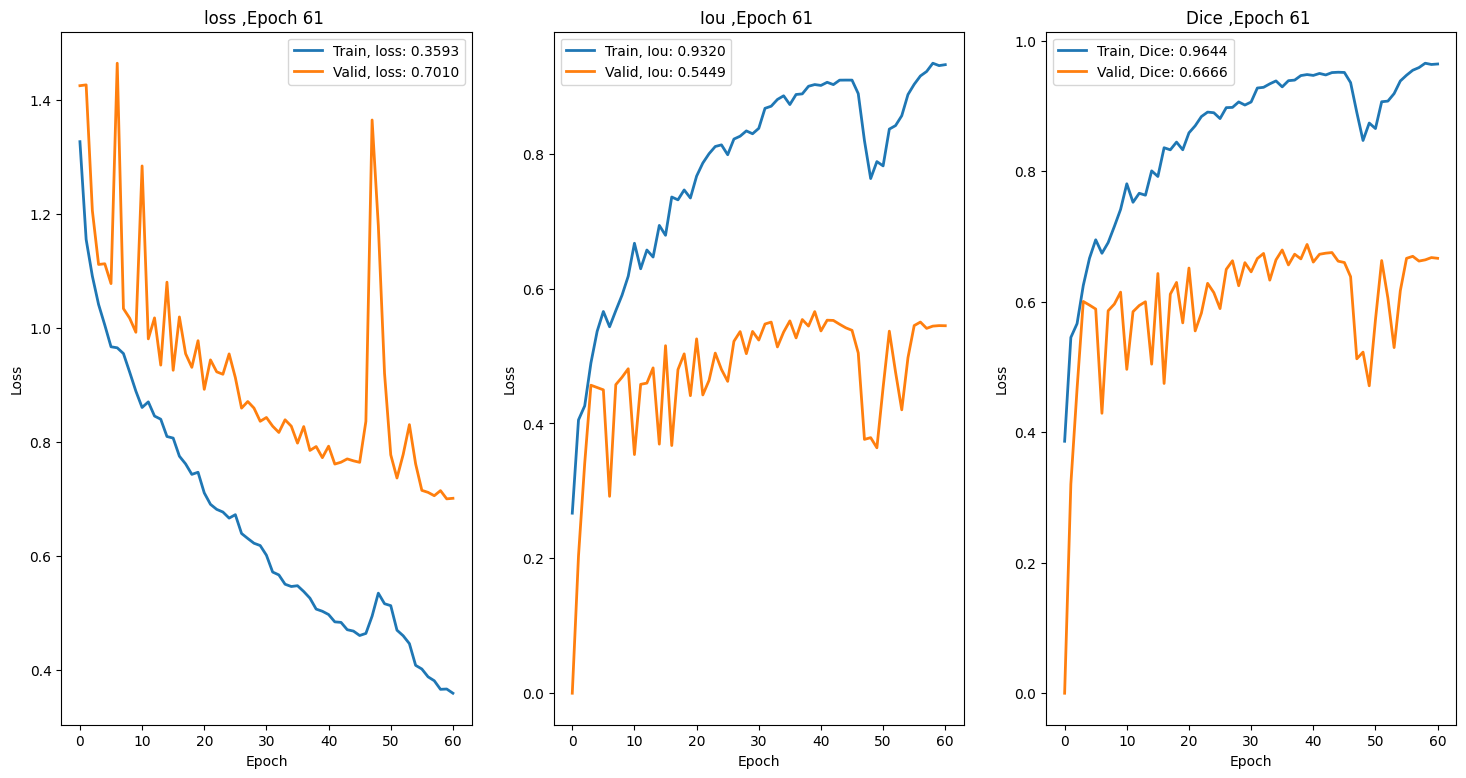

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()